<center><img src="../meta/TRAIDENT.png" width="210"/></center>

# Preprocessing training-datacubes
---

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import xarray as xr
from scipy.stats import gaussian_kde

## Open the zarr dataset 

In [2]:
zarrpath = "/scratch3/users/jdawson/parrot-cube-1-dirty-bad-chunking.zarr"
xrdata = xr.open_dataset(zarrpath, engine='zarr')
cube = xrdata['hdu']

## Get a chunk from the zarr dataset ready for fake signal injection

In [3]:
def getChunk(dataset, rank, blockSize=64):
    dec = (rank * blockSize, rank * blockSize + blockSize)
    ra = (0, 64)
    chunk = cube.isel(**{'DEC--SIN': slice(dec[0], dec[1]), 'RA---SIN': slice(ra[0], ra[1])}).data
    return chunk

In [353]:
chunk = getChunk(cube, 10)
print(f"Size of chunk: {chunk.shape}")

Size of chunk: (4608, 64, 64)


## Define a fake signal injection

In [5]:
def normal_sample(xarray, channel, amplitude, duration):
    ### Creates a normal distribution of points with no scatter
    a = 1 / (duration*np.sqrt(2*np.pi))
    b = np.exp(-0.5 * (((xarray-channel)/duration)**2))
    norm = a * b
    norm = amplitude * norm / norm.max()
    return norm

In [6]:
def inject_fake_signal(cube, row, column, channel, amplitude, duration):
    ### Injects a fake normal signal with amplitude: N * pixel rms, at a certain channel and sigme=duration. 
    xarray = np.arange(cube.shape[0]) # Make an empty array of zeros
    pixel = cube[:, row, column] # GET the current pixel timeseries
    rms = np.sqrt((pixel*pixel).sum()/cube.shape[0]) # Calculate the rms of the pixel 
    signal = normal_sample(xarray, channel, amplitude*rms, duration) # Make the clean signal
    signal[pixel == 0] = 0 # Remove signal where original cube == 0
    cube[:, row, column] += signal # Inject the signal into the cube
    return cube

In [231]:
pixel = inject_fake_signal(chunk, 30, 20, 3000, 1, 1000)

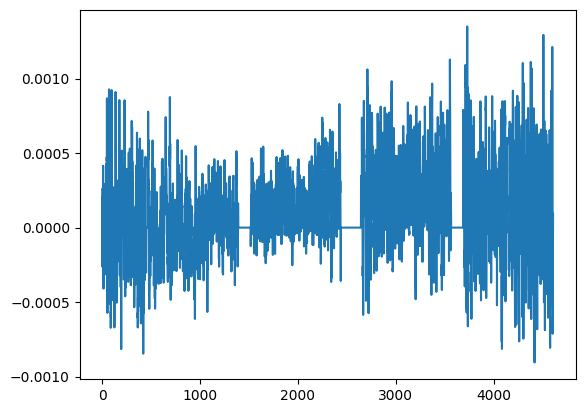

In [232]:
plt.close('all')
plt.figure()
plt.plot(pixel[:,30,20])

# Define a neighbourhood input vector calculator (numpy)

In [286]:
def get_neighbourhood(cube, row, column, channel, Nxy, Nt):
    assert Nxy % 2 != 0, f"Spatial selection Nxy: {Nxy} must be an odd number"
    assert Nt % 2 != 0, f"Temporal selection Nt: {Nt} must be an odd number"
    # Ensure the position is within bounds
    chan_start = min(max(0, channel - Nt), cube.shape[0] - Nt)
    chan_end = min(cube.shape[0], chan_start + Nt)
    row_start = min(max(0, row - Nxy), cube.shape[1] - Nxy)
    row_end = min(cube.shape[1], row_start + Nxy)
    col_start = min(max(0, column - Nxy), cube.shape[2] - Nxy)
    col_end = min(cube.shape[2], col_start + Nxy)
    return cube[chan_start:chan_end, row_start:row_end, col_start:col_end] # Select neighbourhood

def rescale_neighbourhood(neighbourhood):
    # Rescale to avoid moving into high incorrect flux-offset regions
    return neighbourhood - np.median(neighbourhood)

def flux_scale(neighbourhood):
    # Calculate the sum of the flux in the region
    return neighbourhood.sum()

def gradient(neighbourhood, xy, t):
    # Calculate the greedy and smooth gradients in each direction from the center of the neighbourhood
    grad_t = np.gradient(neighbourhood, axis=0)  # Time gradient
    grad_x = np.gradient(neighbourhood, axis=1)  # X gradient
    grad_y = np.gradient(neighbourhood, axis=2)  # Y gradient

    raw_gradient = np.abs([grad_t, grad_x, grad_y])
    greedy_gradient = raw_gradient.max((1,2,3)) # Greedy = looking at the maximum gradient in a direction
    smooth_gradient = np.abs(raw_gradient).mean((1,2,3)) # Smooth = looking at the average gradient in a direction
    return greedy_gradient, smooth_gradient

def anomaly_distance(cube, row, column, channel, Nxy, Nt, a_x, a_y, a_t, a_Nxy, a_Nt):
    # Calculate the position error and bounding box error for the anomaly proximity reward
    distance = np.sqrt((row-a_x)**2 + (column-a_y)**2 + (channel-a_t)**2)
    distance_weighted = 1 - (distance / (cube.shape[0] * cube.shape[1] * cube.shape[2])) # Penalises being a distance approaching the size of the cube away from the target
    bounding_xy = 1 - np.sqrt((Nxy - a_Nxy)**2) / cube.shape[1] # Penalises having a bounding box the size of the cube
    bounding_t = 1 - np.sqrt((Nt-a_Nt)**2) / cube.shape[0] # Penalises having a bounding box the size of the cube
    return distance_weighted, bounding_xy, bounding_t

In [287]:
row, column, channel, Nxy, Nt = 64, 64, 4201, 3, 3
a_x, a_y, a_t, a_Nxy, a_Nt = 64,64,4201,3,3
neighbourhood = get_neighbourhood(cube=chunk, row=row, column=column, channel=channel, Nxy=Nxy, Nt=Nt)
neighbourhood = rescale_neighbourhood(neighbourhood)
flux = flux_scale(neighbourhood)
greedy_grad, smooth_grad = gradient(neighbourhood, 50, 150)
distance_weighted, bounding_xy, bounding_t = anomaly_distance(chunk, row, column, channel, Nxy, Nt, a_x, a_y, a_t, a_Nxy, a_Nt)
input_vector = [flux, greedy_grad[0], greedy_grad[1], greedy_grad[2], smooth_grad[0], smooth_grad[1], smooth_grad[2]]

# Define a neighbourhood input vector calculator (torch)

In [460]:
def get_neighbourhood(cube, row, column, channel, Nxy, Nt):
    # assert Nxy % 2 != 0, f"Spatial selection Nxy: {Nxy} must be an odd number"
    # assert Nt % 2 != 0, f"Temporal selection Nt: {Nt} must be an odd number"
    
    # Ensure the position is within bounds
    chan_start = min(max(0, channel - Nt), cube.shape[0] - Nt)
    chan_end = min(cube.shape[0], chan_start + Nt)
    row_start = min(max(0, row - Nxy), cube.shape[1] - Nxy)
    row_end = min(cube.shape[1], row_start + Nxy)
    col_start = min(max(0, column - Nxy), cube.shape[2] - Nxy)
    col_end = min(cube.shape[2], col_start + Nxy)
    
    return cube[chan_start:chan_end, row_start:row_end, col_start:col_end]  # Select neighbourhood

def rescale_neighbourhood(neighbourhood):
    # Rescale to avoid moving into high incorrect flux-offset regions
    return neighbourhood - torch.median(neighbourhood)

def flux_scale(neighbourhood):
    # Calculate the sum of the flux in the region
    return np.abs(neighbourhood.sum())

def gradient(neighbourhood):
    # Compute gradients manually using torch.diff (PyTorch's equivalent to np.gradient)
    grad_t = torch.diff(neighbourhood, dim=0, prepend=neighbourhood[0:1])  # Temporal gradient, pad at the start
    grad_x = torch.diff(neighbourhood, dim=1, prepend=neighbourhood[:, 0:1, :])  # X gradient, pad at the start
    grad_y = torch.diff(neighbourhood, dim=2, prepend=neighbourhood[:, :, 0:1])  # Y gradient, pad at the start
    # Convert gradients to absolute values
    raw_gradient = torch.abs(torch.stack([grad_t, grad_x, grad_y]))
    # Calculate greedy gradient (maximum gradient in a direction)
    greedy_gradient = raw_gradient.max()
    # Calculate smooth gradient (mean gradient in a direction)
    smooth_gradient = raw_gradient.mean()
    return greedy_gradient, smooth_gradient

# def anomaly_distance(cube, row, column, channel, Nxy, Nt, a_x, a_y, a_t, a_Nxy, a_Nt):
#     # Calculate the position error and bounding box error for the anomaly proximity reward
#     # distance_xy = 1 - (torch.sqrt((row-a_x)**2 + (column-a_y)**2) / torch.sqrt(torch.tensor(cube.shape[1]**2 + cube.shape[2]**2)))
#     distance_x = 2*(1 - (torch.sqrt((row-a_x)**2) / cube.shape[1])) -1  # row distance only
#     distance_y = 2*(1 - (torch.sqrt((column-a_y)**2) / cube.shape[2])) -1  # col distance only
#     # distance_t = 1 - torch.sqrt((channel-a_t)**2) / cube.shape[0]
#     distance_t = 2*(1 - (torch.sqrt((channel-a_t)**2) / cube.shape[0])) -1
#     bounding_xy = 1 - (torch.sqrt((Nxy - a_Nxy)**2) / cube.shape[1])
#     bounding_t = 1 - (torch.sqrt((Nt-a_Nt)**2) / cube.shape[0])
#     return distance_x, distance_y, distance_t#, bounding_xy, bounding_t

def anomaly_distance(cube, row, column, channel, Nxy, Nt, a_x, a_y, a_t, a_Nxy, a_Nt):
    distance_x = torch.abs(row*64-a_x)/64  # row distance only
    distance_y = torch.abs(column*64-a_y)/64  # col distance only
    distance_t = torch.abs(channel*4608-a_t)/4608 # time distance only
    return distance_x, distance_y, distance_t 

def local_scores(cube, row, column, channel, Nxy, Nt, a_x, a_y, a_t, a_Nxy, a_Nt):
    # Calculate the position error and bounding box error for the anomaly proximity reward
    distance_x = 2*(1 - (torch.sqrt((row-a_x)**2) / cube.shape[1])) -1  # row distance only
    distance_y = 2*(1 - (torch.sqrt((column-a_y)**2) / cube.shape[2])) -1  # col distance only
    # distance_t = 1 - torch.sqrt((channel-a_t)**2) / cube.shape[0]
    distance_t = 2*(1 - (torch.sqrt((channel-a_t)**2) / cube.shape[0])) -1
    # bounding_xy = 1 - (torch.sqrt((Nxy - a_Nxy)**2) / cube.shape[1])
    # bounding_t = 1 - (torch.sqrt((Nt-a_Nt)**2) / cube.shape[0])
    return distance_x, distance_x, distance_x

In [35]:
torch_chunk = torch.tensor(chunk)

In [27]:
torch_chunk.shape

torch.Size([4608, 64, 64])

In [30]:
a_x, a_y, a_t, a_Nxy, a_Nt = torch.tensor(40), torch.tensor(8), torch.tensor(1000), torch.tensor(3), torch.tensor(20)
row, column, channel, Nxy, Nt = torch.arange(torch_chunk.shape[1]), torch.arange(torch_chunk.shape[2]), torch.arange(torch_chunk.shape[0]), torch.tensor(7), torch.tensor(31)
local_scores(torch_chunk, row, column, channel, Nxy, Nt, a_x, a_y, a_t, a_Nxy, a_Nt)

tensor([ 0.5660,  0.5664,  0.5668,  ..., -0.5647, -0.5651, -0.5655])

In [31]:
torch.argmax(local_scores(torch_chunk, row, column, channel, Nxy, Nt, a_x, a_y, a_t, a_Nxy, a_Nt))

tensor(1000)

# Define a function for injecting signals into torch tensor cubes

In [348]:
def normal_sample(xarray, channel, amplitude, duration):
    """Creates a normal distribution of points with no scatter using PyTorch."""
    a = 1 / (duration * torch.sqrt(torch.tensor(2 * torch.pi)))
    b = torch.exp(-0.5 * (((xarray - channel) / duration) ** 2))
    norm = a * b
    norm = amplitude * norm / norm.max()
    return norm

def inject_fake_signal(cube, row, column, channel, amplitude, duration):
    """Injects a fake normal signal with amplitude scaled by pixel RMS at a given position."""
    xarray = torch.arange(cube.shape[0], device=cube.device)  # Create an index array
    pixel = cube[:, row, column]  # Get the pixel time series
    rms = torch.sqrt((pixel * pixel).sum() / cube.shape[0])  # Compute RMS
    signal = normal_sample(xarray, channel, amplitude * rms, duration)  # Generate signal
    signal = torch.where(pixel != 0, signal, torch.tensor(0.0, device=cube.device))  # Mask zero pixels
    cube[:, row, column] += signal  # Inject signal
    return cube

# Create a PyTorch policy network for RL with a single injected source

In [492]:
class PolicyNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.ReLU = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=-1)  # Outputs probabilities for movement
    
    def forward(self, x):
        x = self.ReLU(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

# Initialize policy network
input_size = 3  # Matches input_vector dimensions
hidden_size = 6  # Can be adjusted
output_size = 6  # Moves: +row, -row, +col, -col, +channel, -channel
policy = PolicyNet(input_size, hidden_size, output_size)
optimizer = optim.Adam(policy.parameters(), lr=0.01)
criterion = nn.MSELoss()  # Placeholder loss (we will use REINFORCE-like updates)

# Define action mapping
actions = [
    torch.tensor([1, 0, 0]), torch.tensor([-1, 0, 0]),  # Row movement
    torch.tensor([0, 1, 0]), torch.tensor([0, -1, 0]),  # Column movement
    torch.tensor([0, 0, 11]), torch.tensor([0, 0, -11])  # Channel movement
]

# Training loop
num_steps = 50000
positions = [] 

row, column, channel, Nxy, Nt = torch.tensor(0.1), torch.tensor(0.1), torch.tensor(0.1), torch.tensor(3), torch.tensor(21)
a_x, a_y, a_t, a_Nxy, a_Nt = torch.tensor(40), torch.tensor(40), torch.tensor(1000), torch.tensor(3), torch.tensor(21)

# Scaling limits for neighborhood size
Nxy_min, Nxy_max = 3, 3
Nt_min, Nt_max = 21, 21

def get_input_vector():
    tneighbourhood = get_neighbourhood(cube=torch_chunk, row=row, column=column, channel=channel, Nxy=Nxy, Nt=Nt)
    tneighbourhood = rescale_neighbourhood(tneighbourhood)
    distance_x, distance_y, distance_t = anomaly_distance(torch_chunk, row, column, channel, Nxy, Nt, a_x, a_y, a_t, a_Nxy, a_Nt)
    return torch.stack([distance_x, distance_y, distance_t])

running_loss, running_reward, running_action_probs, running_inputs  = [],[],[],[]

for step in range(num_steps):
    positions.append((row.item()*64, column.item()*64, channel.item()*4608))
    
    input_vector = get_input_vector()
    running_inputs.append(input_vector)
    action_probs = policy(input_vector.float())
    running_action_probs.append(action_probs)
    action_index = torch.multinomial(action_probs, 1)
    move = actions[action_index]

    # Apply movement
    row = torch.clamp(row*64 + move[0], Nxy_max, torch_chunk.shape[1] - Nxy_max)/64
    column = torch.clamp(column*64 + move[1], Nxy_max, torch_chunk.shape[2] - Nxy_max)/64
    channel = torch.clamp(channel*4608 + move[2], Nt_max, torch_chunk.shape[0] - Nt_max)/4608

    reward = torch.tensor((abs(row*64 - a_x)/64 + abs(column*64 - a_y)/64 + abs(channel*4608 - a_t))/4608, dtype=torch.float)# * torch_chunk.shape[1]/torch_chunk.shape[0])
    running_reward.append(reward)
   
    loss = reward * action_probs[action_index]
    running_loss.append(loss)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

all_loss = torch.tensor(running_loss).detach().numpy()
all_rewards = torch.stack(running_reward).detach().numpy()
all_action_probs = torch.stack(running_action_probs).detach().numpy()
all_inputs = torch.stack(running_inputs).detach().numpy()

/tmp/ipykernel_877641/2656167001.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reward = torch.tensor((abs(row*64 - a_x)/64 + abs(column*64 - a_y)/64 + abs(channel*4608 - a_t))/4608, dtype=torch.float)# * torch_chunk.shape[1]/torch_chunk.shape[0])


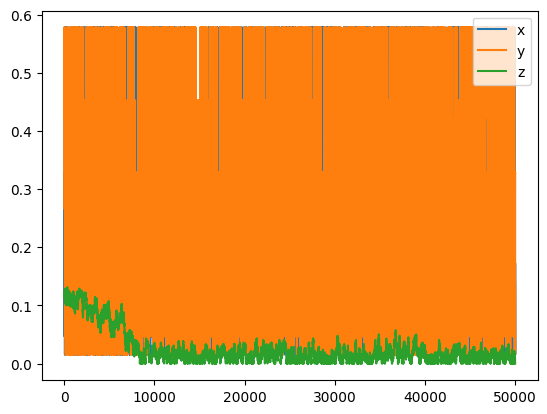

In [493]:
plt.close('all')
plt.figure()
plt.plot(all_inputs[:,0], label = 'x')
plt.plot(all_inputs[:,1], label = 'y')
plt.plot(all_inputs[:,2], label = 'z')
plt.legend()

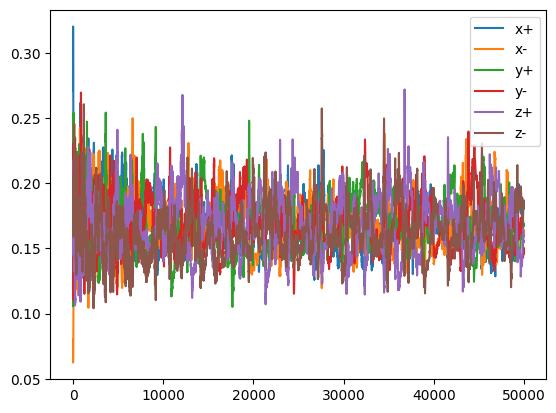

In [494]:
plt.close('all')
plt.figure()
plt.plot(all_action_probs[:,0], label = 'x+')
plt.plot(all_action_probs[:,1], label = 'x-')
plt.plot(all_action_probs[:,2], label = 'y+')
plt.plot(all_action_probs[:,3], label = 'y-')
plt.plot(all_action_probs[:,4], label = 'z+')
plt.plot(all_action_probs[:,5], label = 'z-')
plt.legend()

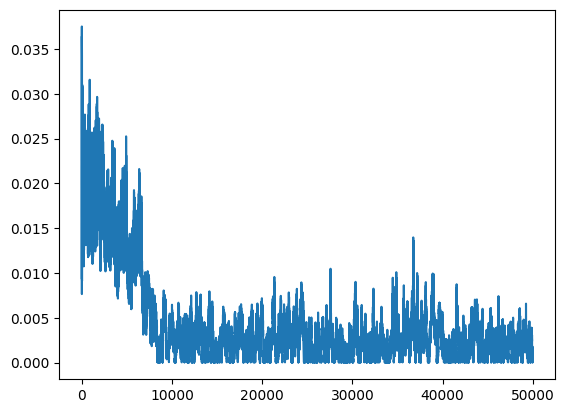

In [495]:
plt.figure()
plt.plot(all_loss)

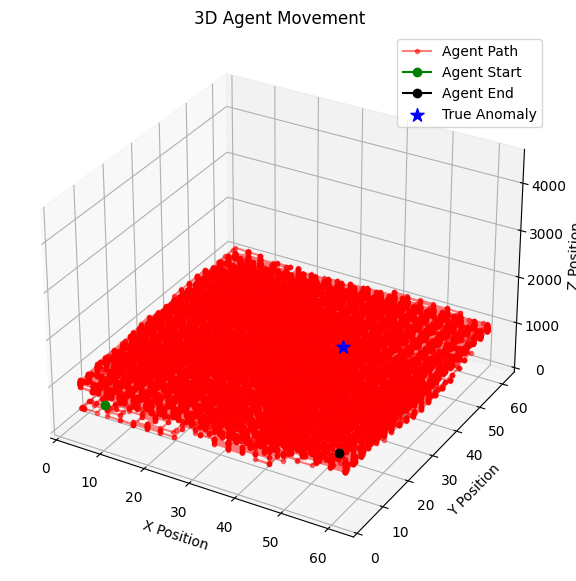

In [483]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

positions = np.array(positions)
x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]

# Define cube boundaries
x_min, x_max = 0, chunk.shape[1]
y_min, y_max = 0, chunk.shape[2]
z_min, z_max = 0, chunk.shape[0]

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot agent movement
ax.plot(x, y, z, color='red', marker='.', alpha=0.5, label='Agent Path')
ax.plot(x[0], y[0], z[0], color='green', marker='o', label='Agent Start')
ax.plot(x[-1], y[-1], z[-1], color='black', marker='o', label='Agent End')

# Mark true anomaly (assuming first position is the anomaly)
ax.scatter(40, 40, 1000, color='blue', s=100, marker='*', label='True Anomaly')

# Set labels
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_zlabel("Z Position")
ax.set_title("3D Agent Movement")

# Set boundaries
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_zlim([z_min, z_max])

ax.legend()
plt.show()

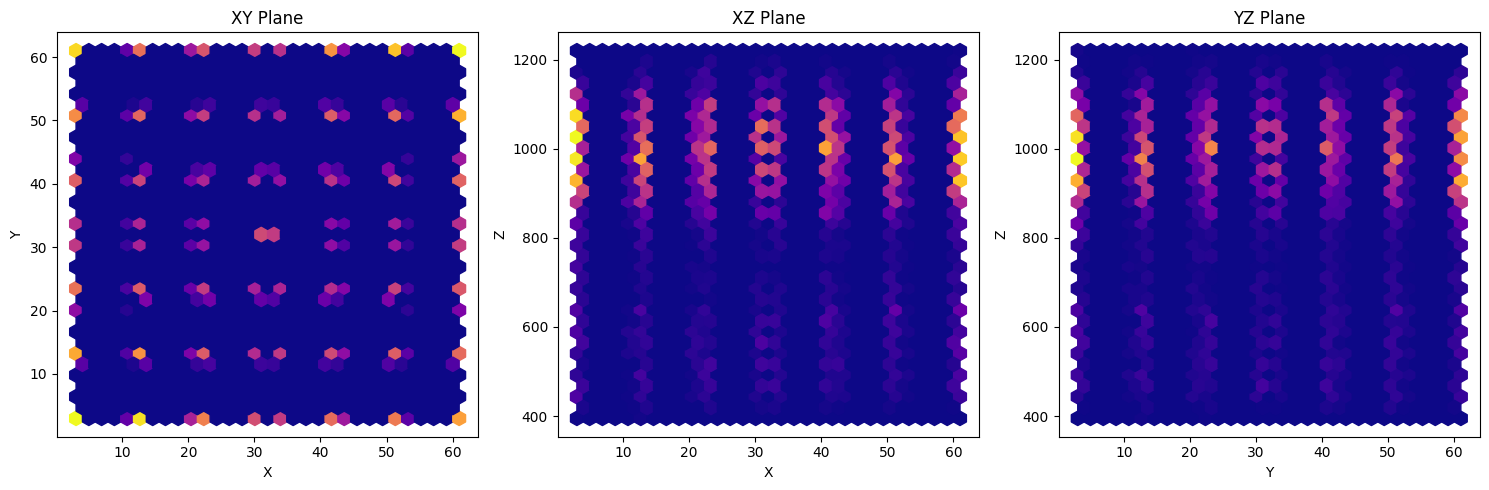

In [499]:
x, y, z = np.array(positions).T  # Unpack x, y, z coordinates

# Define a function to plot 2D histograms
def plot_2d_hist(ax, x_data, y_data, xlabel, ylabel, cmap="plasma"):
    # Create a 2D histogram
    hb = ax.hexbin(x_data, y_data, gridsize=30, cmap=cmap)
    
    # Add labels and colorbar
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return hb

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# XY plane 2D histogram
hb1 = plot_2d_hist(axes[0], x, y, "X", "Y")
axes[0].set_title("XY Plane")

# XZ plane 2D histogram
hb2 = plot_2d_hist(axes[1], x, z, "X", "Z")
axes[1].set_title("XZ Plane")

# YZ plane 2D histogram
hb3 = plot_2d_hist(axes[2], y, z, "Y", "Z")
axes[2].set_title("YZ Plane")

plt.tight_layout()
plt.show()

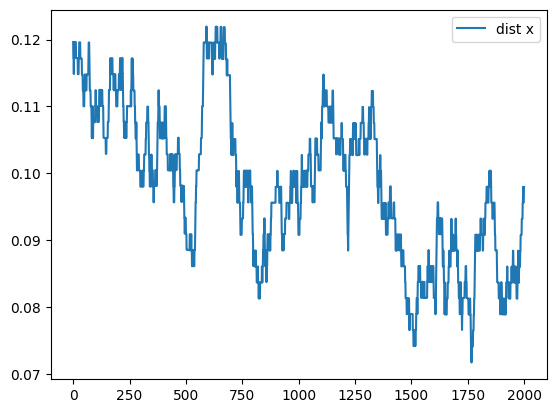

In [475]:
plt.close('all')
plt.figure()
# plt.plot(all_rewards[:,0], label = 'flux')
# plt.plot(all_rewards[:,1], label = 'greedy grad')
# plt.plot(all_rewards[:,2], label = 'smooth grad')
plt.plot(all_rewards, label = 'dist x')
# plt.plot(all_rewards[:,1], label = 'dist y')
# plt.plot(all_rewards[:,2], label = 'dist t')
# plt.plot(all_rewards[:,2], label = 'bound xy')
# plt.plot(all_rewards[:,3], label = 'bound t')
plt.legend()

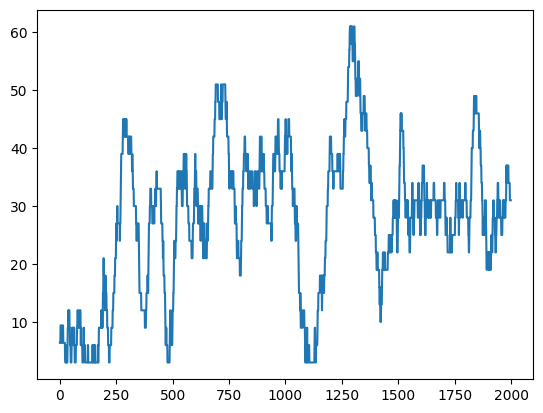

In [478]:
plt.figure()
plt.plot(x)

In [456]:
np.median(x)

34.0